In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from operator import itemgetter
import pygraphviz

In [2]:
os.getcwd()

'/Users/Sophie/Documents/GitHub/Analysis_and_Modelling_Social_Interactions'

# Load the data

In [3]:
# import data
df = pd.read_excel('European_electricity_network_vFinal.xlsx', sheet_name='2009')
df.head()

,Origin_Country,Country_Code,AL,AT,BA,BE,BG,CH,CZ,DE,...,NL,NO,PL,PT,RO,RS,SE,SI,SK,TR
0,Albania,AL,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,425.0,0.0,0.0,0.0,0.0
1,Austria,AT,0.0,NaN,0.0,0.0,0.0,8653.0,262.0,7061.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2527.0,0.0,0.0
2,Bosnia and Herzegovina,BA,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,361.0,0.0,0.0,0.0,0.0
3,Belgium,BE,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,3773.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bulgaria,BG,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,230.0,1184.0,0.0,0.0,0.0,0.0


In [4]:
# drop unnecessary columns
df_elec = df.drop(['Origin_Country'], axis=1)

# Convert the wide table to long table
Country_list = list(df_elec.columns)
df_elec = df_elec.melt(id_vars=['Country_Code'], value_vars=(Country_list[1:]), var_name='Destination', value_name='Electricity_Flow')
df_elec.rename(columns={'Country_Code':'Origin'}, inplace=True)

# Sort the table based on origin country's name
df_elec.sort_values('Origin', inplace=True, ascending=True)

# Delete NAs (when Origin=Destination)
df_elec.dropna(axis=0, inplace=True) 

# Delete zero-value rows
df_elec = df_elec[df_elec.Electricity_Flow != 0]
df_elec.reset_index(drop=True, inplace=True)

df_elec.head()

,Origin,Destination,Electricity_Flow
0,AL,GR,61.0
1,AL,ME,47.0
2,AL,RS,425.0
3,AT,SI,2527.0
4,AT,DE,7061.0


In [5]:
len(df_elec)

113

# Preparation before creating network

## Create nodes list

In [6]:
node = df_elec['Origin'].unique()
node_list = list(node)
node_list[:5]

['AL', 'AT', 'BA', 'BE', 'BG']

## Calculate edge weights

In [7]:
ebunch = list(df_elec.to_records(index=False))

In [8]:
# use "Electricity_Flow" as weights
weights_list = list(df_elec['Electricity_Flow'])

In [9]:
edge_width_list = [None]*len(weights_list)

# use max(weight) to normalize the size of edges
max_weights = max(weights_list)

for i, weight in enumerate(weights_list):
    edge_width_list[i] = weights_list[i]/max_weights*5.5

# create an array of edge widths to be assigned to network
edge_width = np.asarray(edge_width_list)

## Calculate node size: total export of each country

In [10]:
# calculate total export for each country
df_total_export = df_elec.groupby(['Origin'], as_index=False).sum()
df_total_export.columns = ['Country', 'Export']
df_total_export.head()

,Country,Export
0,AL,533.0
1,AT,21094.0
2,BA,5836.0
3,BE,11314.0
4,BG,7634.0


In [11]:
# convert export dataframe to np array, to be assigned to node_size
total_export = np.asarray(df_total_export['Export'])

In [12]:
# check top exporting countries
df_total_export_sorted = df_total_export.sort_values(by='Export', ascending=False)
df_total_export_sorted.head()

,Country,Export
7,DE,54849.0
12,FR,43281.0
5,CH,31782.0
6,CZ,22232.0
1,AT,21094.0


# Create networks
## Directed network

In [13]:
G = nx.DiGraph()
G.add_nodes_from(node_list)
G.add_weighted_edges_from(ebunch_to_add=ebunch, weight='weight')

/usr/local/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


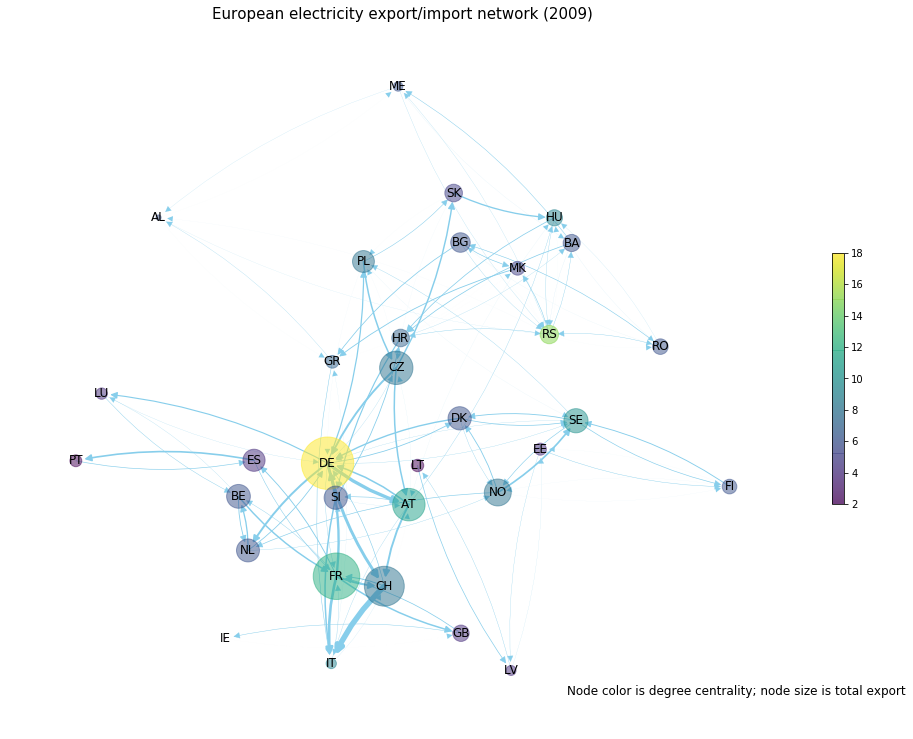

In [14]:
pos = nx.spring_layout(G, k=9, scale=6, seed=33)

node_size = total_export/20
node_color = [float(G.degree(i)) for i in G]

plt.figure(figsize=(15,13))

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, alpha=0.5)
edges = nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='skyblue', 
                       arrowstyle='-|>', arrowsize=14,
                       connectionstyle='arc3,rad=0.1')
nx.draw_networkx_labels(G, pos, font_size=12)

plt.title('European electricity export/import network (2009)', fontsize=15)
plt.text(2.5,-5,'Node color is degree centrality; node size is total export', fontsize=12)
cbar = plt.colorbar(mappable=nodes, cax=None, ax=None, fraction=0.015, pad=0.04)

plt.axis('off')
plt.show()

In [15]:
list(G.degree())

[('AL', 6),
 ('AT', 11),
 ('BA', 6),
 ('BE', 6),
 ('BG', 6),
 ('CH', 8),
 ('CZ', 8),
 ('DE', 18),
 ('DK', 6),
 ('EE', 4),
 ('ES', 4),
 ('FI', 6),
 ('FR', 12),
 ('GB', 4),
 ('GR', 7),
 ('HR', 7),
 ('HU', 9),
 ('IE', 2),
 ('IT', 9),
 ('LT', 2),
 ('LU', 4),
 ('LV', 4),
 ('ME', 6),
 ('MK', 5),
 ('NL', 6),
 ('NO', 8),
 ('PL', 8),
 ('PT', 2),
 ('RO', 6),
 ('RS', 15),
 ('SE', 10),
 ('SI', 6),
 ('SK', 5)]